# Multi-Class Classification on Medical MNIST
1. Bayes classifier - GMM, Gaussian
2. Naive Bayes
3. MLE
4. MAP

## Note
1. in multi-class, there is NO roc curve
2. cross validate on '80' split of data and get train and val error/acc (Discard the models learnt here in every step of cross validation)
3. finally, using the '20' split of data get the confusion matrix and test acc/error. This is obtained using the model trained on complete Train set

In [1]:
import pandas as pd
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
import PIL.Image as Image
import math
from sklearn import decomposition

## Classification Performance Metrics

In [2]:
'''
input-
y_pred, y_true shape is (n,) (NOT in one-hot representation)
multi-class such that ypred,ytrue has values in 0,1,2,..,label-1

In confusion matrix, it is assumed that there are 6 labels.

output-
precisions, recalls, F1s numpy arrays of shape (no. of labels,)
confusion matrix - numpy matrix (label,label)
'''
def classification_performance_metrics(y_pred, y_true, exp_name):
    
    y_pred = y_pred.astype('uint8')
    y_true = y_true.astype('uint8')
    
    confusion_matrix = np.zeros((6,6)) #left side - actual, top side - predicted
    for true_label in range(6):
        true_indices = y_true==true_label
        for pred_label in range(6):
            check_pred_labels = y_pred[true_indices]
            confusion_matrix[true_label][pred_label]= (check_pred_labels == pred_label).sum()
    confusion_matrix/=(confusion_matrix.sum(axis=1,keepdims=True))    #normalise it - dividing by column sum

    n=y_true.shape
    
    tp_indices = y_pred==y_true
    tp = y_true[tp_indices]
    
    true_y_per_class = np.bincount(y_true)
    labels = true_y_per_class.shape[0]
    
    tp_per_class = np.zeros((labels,))
    tp_per_class[:np.bincount(tp).shape[0]] = np.bincount(tp)
    predicted_y_per_class = np.zeros((labels,))
    predicted_y_per_class[:np.bincount(y_pred).shape[0]] = np.bincount(y_pred)
    
    precisions, recalls, F1s = [], [], []
    #precision, recall, F1 for each class
    for i in range(tp_per_class.shape[0]):
        TP = tp_per_class[i]
        TN = tp_per_class.sum() - TP
        FP = predicted_y_per_class[i] - TP
        FN = true_y_per_class[i] - TP
        
        precision = TP/(TP+FP) if TP+FP!=0 else 0
        recall = TP/(TP+FN) if TP+FN!=0 else 0
        F1 = 2*TP/(2*TP+FP+FN) if TP+FP+FN!=0 else 0
        FPR = FP/(FP+TN) if FP+TN!=0 else 0

        precisions.append(precision)
        recalls.append(recall)
        F1s.append(F1)
        
    if exp_name!=None:
        #save csv files
        categories=["AbdomenCT","BreastMRI","ChestCT","CXR","Hand","HeadCT"]
        dikt = {}
        dikt['Precision']=np.round(precisions,3)
        dikt['Recall']=np.round(recalls,3)
        dikt['F1']=np.round(F1s,3)

        df = pd.DataFrame(data=dikt,index=categories)
        df.to_csv('%s_perClass.csv'%exp_name)
        df = pd.DataFrame(data=np.round(confusion_matrix,3),index=categories,columns=categories)
        df.to_csv('%s_ConfMat.csv'%exp_name)
    
    
    precisions=np.array(precisions)
    recalls=np.array(recalls)
    F1s=np.array(F1s)
    macro_F1=F1s.mean()
    
    return precisions, recalls, F1s, macro_F1, confusion_matrix

def accuracy(y_pred, y_true):
    return (y_pred==y_true).sum()/y_true.shape[0]

### Data Preprocessing

In [3]:
category = {}
category[0] = "AbdomenCT"
category[1] = "BreastMRI"
category[2] = "ChestCT"
category[3] = "CXR"
category[4] = "Hand"
category[5] = "HeadCT"
path = './Medical_MNIST/'

In [ ]:
# train_data, test_data = [], []
# for i in range(6):
#     data = []
#     print(category[i])
#     imagepath = path + category[i] 
#     for images in os.listdir(imagepath):
#         image = np.array(Image.open(os.path.join(imagepath, images)))
#         image = np.append(image,i)
#         data.append(image.astype('uint8'))
#     train_data+=data[0:int(0.8*len(data))]
#     test_data+=data[int(0.8*len(data)):]
# train_data=np.array(train_data)
# test_data=np.array(test_data)
# print(train_data.shape, test_data.shape)

In [5]:
# np.save('train.npy',train)
# np.save('test.npy',test)
train_data=np.load('train.npy').astype(np.float64) #loading as float because i have to normalise later
np.random.shuffle(train_data)
TEST_data=np.load('test.npy').astype(np.float64)
print(train_data.shape, train_data.dtype)
print(TEST_data.shape, TEST_data.dtype)

(47163, 4097) float64
(11791, 4097) float64


breast MRI data size is not 10000

In [6]:
pca=decomposition.PCA(n_components=2)
pca.fit(train_data[:,:-1])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [7]:
transformed_train_data_X = pca.transform(train_data[:,:-1])
transformed_TEST_data_X = pca.transform(TEST_data[:,:-1])

train_data = np.hstack((transformed_train_data_X,train_data[:,-1:]))
TEST_data = np.hstack((transformed_TEST_data_X, TEST_data[:,-1:]))
print(train_data.shape, TEST_data.shape)

(47163, 3) (11791, 3)


In [8]:
#computing mean and stddev from whole train set (0.80*total data)
mean = train_data[:,:-1].mean(axis=0,keepdims=True)
stddev = train_data[:,:-1].std(axis=0,keepdims=True)

In [9]:
train_data[:,:-1]-=mean
TEST_data[:,:-1]-=mean
train_data[:,:-1]/=stddev
TEST_data[:,:-1]/=stddev

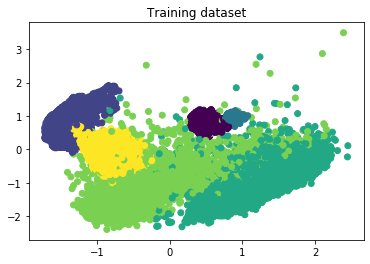

In [32]:
plt.title('Training dataset')
plt.scatter(train_data[:,0],train_data[:,1],c=train_data[:,-1])
plt.savefig('TrainingDataset.png')
plt.show()

In [10]:
Cross_Validation_data=np.array_split(train_data,5)
print(len(Cross_Validation_data))

X_TEST,y_TEST = TEST_data[:,:-1],TEST_data[:,-1:]
print(X_TEST.shape, y_TEST.shape)

5
(11791, 2) (11791, 1)


In [11]:
print(train_data.shape, Cross_Validation_data[0].shape)
print('train size = {}'.format(train_data.shape[0]-Cross_Validation_data[0].shape[0]))
print('val size = {}'.format(Cross_Validation_data[0].shape[0]))
print('test size = {}'.format(TEST_data.shape[0]))

(47163, 3) (9433, 3)
train size = 37730
val size = 9433
test size = 11791


# Bayes Classifier using Parametric Estimation of Class conditional densities

# 1. Multivariate Gaussian

In [11]:
# def multi_variate_gaussian(x, mu, sigma): #taken log because of curse of dimensionality
#     # x,mu shape (d,) 
#     y = -((x-mu).T.dot(np.linalg.pinv(sigma))).dot(x-mu)/2
#     y = y - np.log(np.linalg.det(sigma))/2
#     return y

def multi_variate_gaussian(x, mu, sigma):
    y = ((x-mu).T.dot(np.linalg.inv(sigma))).dot(x-mu)
    y = -y/2
    y = np.exp(y)
    constant = pow(2*3.14,x.shape[0])
    constant = constant*np.linalg.det(sigma)
    constant = pow(constant, 1/2)
    y = y/constant
    return y

def bayes_classifier(X, priors, MLE):
    #posteriors (not normalised)
    y_pred = np.zeros((X.shape[0],),dtype=np.uint8)
    for i in range(X.shape[0]):
        x=X[i]
        posteriors=[]
        for j in range(6):
             posteriors.append(priors[j]*multi_variate_gaussian(x, MLE['mu_%u'%j], MLE['sigma_%u'%j]))
        y_pred[i]=posteriors.index(max(posteriors))
    return y_pred

def bayes_classifier_MVG(train, test): #train,test = X|Y
    #separate into classes in train set to find MLE for class conditional densities
    train_classes=[]
    priors=[]
    for i in range(6):
        train_class_i=train[train[:,-1]==i]
        train_classes.append(train_class_i)    
        priors.append(train_class_i.shape[0]/train.shape[0])
    
    #compute MLE for mu and sigma
    MLE={}
    for i in range(6):
        X=train_classes[i][:,:-1]
        MLE['mu_{}'.format(i)]=X.mean(axis=0)
        MLE['sigma_{}'.format(i)]=np.cov(X.T)
        
    #use bayes classifier
    y_pred_train = bayes_classifier(train[:,:-1], priors, MLE)
    y_train = train[:,-1]
    y_pred_test = bayes_classifier(test[:,:-1], priors, MLE)
    y_test = test[:,-1]
    return y_pred_train,y_pred_test

In [21]:
#cross validate to get per-class precision, recall, F1, macro F1, accuracy
precisions_CV, recalls_CV, F1s_CV, macro_F1_CV, train_acc_CV, test_acc_CV = [],[],[],[],[],[]

for i,validation_data in enumerate(Cross_Validation_data):
    print('validating on part %u'%i)
    remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
    train = remaining_data_for_training
    test = validation_data
    y_pred_train, y_pred_test = bayes_classifier_MVG(train, test)

    train_acc_CV.append(accuracy(y_pred_train, train[:,-1]))
    test_acc_CV.append(accuracy(y_pred_test, test[:,-1]))
    
    tupple = classification_performance_metrics(y_pred_test, test[:,-1],None)
    precisions_CV.append(tupple[0])
    recalls_CV.append(tupple[1])
    F1s_CV.append(tupple[2])
    macro_F1_CV.append(tupple[3]) #tupple[4] is confusion matrix
    
precisions, recalls, F1s, macro_F1, train_acc, test_acc = sum(precisions_CV)/5, sum(recalls_CV)/5, sum(F1s_CV)/5, sum(macro_F1_CV)/5, sum(train_acc_CV)/5, sum(test_acc_CV)/5

validating on part 0
validating on part 1
validating on part 2
validating on part 3
validating on part 4


In [22]:
print('validation acc =',test_acc,"; validation macro F1 =",macro_F1)

validation acc = 0.9709094572345276 ; validation macro F1 = 0.9706867963556303


In [23]:
#now finally, train on complete TRAIN set and evaluate TEST
y_pred_train, y_pred_test = bayes_classifier_MVG(train_data, TEST_data)
test_metrics=classification_performance_metrics(y_pred_test, TEST_data[:,-1],'bayes_gaussian')
print('train acc, TEST acc, macro F1 score')
print( accuracy(y_pred_train, train_data[:,-1]), accuracy(y_pred_test, TEST_data[:,-1]), test_metrics[-2] )

train acc, TEST acc, macro F1 score
0.9711638360579268 0.9694682384869816 0.969287564228226


# 2. Multivariate Gaussian with statistical independence btw features - Naive Bayes

In [24]:
def uni_variate_gaussian(x, mu, sigma):
    y = -(x-mu)**2
    y = y/((sigma)**2)
    y = y/2
    y = np.exp(y)
    constant = pow(2*3.14,1/2)
    constant = constant*sigma
    y = y/constant
    return y

def bayes_classifier(X, priors, MLE):
    #posteriors (not normalised)
    y_pred = np.zeros((X.shape[0],),dtype=np.uint8)
    for i in range(X.shape[0]):
        x=X[i]
        posteriors=[]
        for j in range(6):
            Q_j = priors[j]
            for k in range(x.shape[0]):
                Q_j *= uni_variate_gaussian(x[k], MLE['mu_%u_%u'%(j,k)], MLE['sigma_%u_%u'%(j,k)])
            posteriors.append(Q_j)
        y_pred[i]=posteriors.index(max(posteriors))
    return y_pred

def bayes_classifier_MuVG(train, test): #train,test = X|Y
    #separate into classes in train set to find MLE for class conditional densities
    train_classes=[]
    priors=[]
    for i in range(6): #classes
        train_class_i=train[train[:,-1]==i]
        train_classes.append(train_class_i)    
        priors.append(train_class_i.shape[0]/train.shape[0])
    
    #compute MLE for mu and sigma
    MLE={}
    for i in range(6):
        X=train_classes[i][:,:-1]
        for j in range(X.shape[1]):
            MLE['mu_%u_%u'%(i,j)]=X[:,j].mean(axis=0)
            MLE['sigma_%u_%u'%(i,j)]=X[:,j].std(axis=0)

    #use bayes classifier
    y_pred_train = bayes_classifier(train[:,:-1], priors, MLE)
    y_train = train[:,-1]
    y_pred_test = bayes_classifier(test[:,:-1], priors, MLE)
    y_test = test[:,-1]
    
    return y_pred_train,y_pred_test

In [26]:
#cross validate to get per-class precision, recall, F1, macro F1, accuracy
precisions_CV, recalls_CV, F1s_CV, macro_F1_CV, train_acc_CV, test_acc_CV = [],[],[],[],[],[]

for i,validation_data in enumerate(Cross_Validation_data):
    print('validating on part %u'%i)
    remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
    train = remaining_data_for_training
    test = validation_data
    y_pred_train, y_pred_test = bayes_classifier_MuVG(train, test)

    train_acc_CV.append(accuracy(y_pred_train, train[:,-1]))
    test_acc_CV.append(accuracy(y_pred_test, test[:,-1]))
    
    tupple = classification_performance_metrics(y_pred_test, test[:,-1],None)
    precisions_CV.append(tupple[0])
    recalls_CV.append(tupple[1])
    F1s_CV.append(tupple[2])
    macro_F1_CV.append(tupple[3]) #tupple[4] is confusion matrix

precisions, recalls, F1s, macro_F1, train_acc, test_acc = sum(precisions_CV)/5, sum(recalls_CV)/5, sum(F1s_CV)/5, sum(macro_F1_CV)/5, sum(train_acc_CV)/5, sum(test_acc_CV)/5

validating on part 0
validating on part 1
validating on part 2
validating on part 3
validating on part 4


In [27]:
print('validation acc =',test_acc,"; validation macro F1 =",macro_F1)

validation acc = 0.9642940520560745 ; validation macro F1 = 0.9640895266901234


In [28]:
#now finally, train on complete TRAIN set and evaluate TEST
y_pred_train, y_pred_test = bayes_classifier_MuVG(train_data, TEST_data)
test_metrics=classification_performance_metrics(y_pred_test, TEST_data[:,-1],'NaiveBayes')
print('train acc, TEST acc, macro F1 score')
print( accuracy(y_pred_train, train_data[:,-1]), accuracy(y_pred_test, TEST_data[:,-1]), test_metrics[-2] )

train acc, TEST acc, macro F1 score
0.9643364501834065 0.9638707488762616 0.9636694647611704


# 3. Gaussian mixture model - class conditional density

In [12]:
import random as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def random_parameters(data, K):
    """ init the means, covariances and mixing coefs"""
    cols = (data.shape)[1]
 
    mu = np.zeros((K, cols))
    for k in range(K):
        idx = int(np.floor(rd.random()*len(data)))
        for col in range(cols):
            mu[k][col] += data[idx][col]
 
    sigma = []
    for k in range(K):
        sigma.append(np.cov(data.T))
 
    pi = np.ones(K)*1.0/K
 
    return mu, sigma, pi

def e_step(data, K, mu, sigma, pi):
    idvs = (data.shape)[0]
    cols = (data.shape)[1]
 
    resp = np.zeros((idvs, K))
 
    for i in range(idvs):
        for k in range(K):
            resp[i][k] = pi[k]*gaussian(data[i], mu[k], sigma[k])/likelihood(data[i], K, mu, sigma, pi)

    return resp

def log_likelihood(data, K, mu, sigma, pi):
    """ marginal over X """
    log_likelihood = 0.0
    for n in range (len(data)):
        log_likelihood += np.log(likelihood(data[n], K, mu, sigma, pi))
    return log_likelihood 

 
def likelihood(x, K, mu, sigma, pi):
    rs = 0.0
    for k in range(K):
        rs += pi[k]*gaussian(x, mu[k], sigma[k])
    return rs


def m_step(data, K, resp):
    """ find the parameters that maximize the log-likelihood given the current resp."""
    idvs = (data.shape)[0]
    cols = (data.shape)[1]
    
    mu = np.zeros((K, cols))
    sigma = np.zeros((K, cols, cols))
    pi = np.zeros(K)

    marg_resp = np.zeros(K)
    for k in range(K):
        for i in range(idvs):
            marg_resp[k] += resp[i][k]
            mu[k] += (resp[i][k])*data[i]
        mu[k] /= marg_resp[k]

        for i in range(idvs):
            #x_i = (np.zeros((1,cols))+data[k])
            x_mu = np.zeros((1,cols))+data[i]-mu[k]
            sigma[k] += (resp[i][k]/marg_resp[k])*x_mu*x_mu.T

        pi[k] = marg_resp[k]/idvs        
        
    return mu, sigma, pi


def gaussian(x, mu, sigma):
    """ compute the pdf of the multi-var gaussian """
    idvs = len(x)
    norm_factor = (2*np.pi)**idvs

    norm_factor *= np.linalg.det(sigma)
    norm_factor = 1.0/np.sqrt(norm_factor)

    x_mu = np.matrix(x-mu)

    rs = norm_factor*np.exp(-0.5*x_mu*np.linalg.inv(sigma)*x_mu.T)
    return rs


def EM(data, K, threshold):
    converged = False
    mu, sigma, pi = random_parameters(data, K)
    
    l=[]
    current_log_likelihood = log_likelihood(data, K, mu, sigma, pi)
    max_iter = 30
    for it in range(max_iter):
        resp = e_step(data, K, mu, sigma, pi)
        mu, sigma, pi = m_step(data, K, resp)
        l.append(current_log_likelihood[0,0])
        new_log_likelihood = log_likelihood(data, K, mu, sigma, pi)
#         if (abs(new_log_likelihood-current_log_likelihood) < threshold):
#             converged = True
#             break

        current_log_likelihood = new_log_likelihood
    
    l.append(current_log_likelihood[0,0])
    
    return l, mu, sigma

In [13]:
def bayes_classifier_GMM(train, test, n_components): #train,test = X|Y
    train_classes=[]
    priors=[]
    for i in range(6):
        train_class_i=train[train[:,-1]==i]
        train_classes.append(train_class_i)    
        priors.append(train_class_i.shape[0]/train.shape[0])
    
    #fit GMM using MLE for train set
    GMM_parameters={}
    for i in range(6):
        X=train_classes[i][:,:-1]
        GMM_parameters['mu_%u'%i], GMM_parameters['sigma_%u'%i], GMM_parameters['log_likelihood_%u'%i] = EM(X,n_components,0.001)

    #use bayes classifier
    y_pred_train = bayes_classifier(train[:,:-1], priors, GMM_parameters, n_components=n_components)
    y_train = train[:,-1]
    y_pred_test = bayes_classifier(test[:,:-1], priors, GMM_parameters, n_components=n_components)
    y_test = test[:,-1]
    
    return y_pred_train,y_pred_test
    
def bayes_classifier(X, priors, GMM_parameters, n_components):
    #posteriors (not normalised)
    Q=[]
    for j in range(6): #classes
        f_j = predict(X, GMM_parameters['mu_%u'%j], GMM_parameters['sigma_%u'%j], n_components)
        Q_j = [priors[j]*f[0,0] for f in f_j]
        Q.append(Q_j)
    Q=np.array(Q) #shape = 6,n
    y_pred=Q.argmax(axis=0)
    
    return y_pred

def predict(X, mu, sigma, n_components):
    probabs = []
    for n in range(len(X)):
        probabs.append([gaussian(X[n], mu[k], sigma[k]) for k in range(n_components)])
    final_probs = []
    for probab in probabs:
        final_probs.append(max(probab))
    return final_probs

In [14]:
#cross validate to get per-class precision, recall, F1, macro F1, accuracy
precisions_CV, recalls_CV, F1s_CV, macro_F1_CV, train_acc_CV, test_acc_CV = [],[],[],[],[],[]
for i,validation_data in enumerate(Cross_Validation_data):
    print('validating on part %u'%i)
    remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
    train = remaining_data_for_training
    test = validation_data
    y_pred_train, y_pred_test = bayes_classifier_GMM(train, test, n_components=2)

    train_acc_CV.append(accuracy(y_pred_train, train[:,-1]))
    test_acc_CV.append(accuracy(y_pred_test, test[:,-1]))
    
    tupple = classification_performance_metrics(y_pred_test, test[:,-1])
    precisions_CV.append(tupple[0])
    recalls_CV.append(tupple[1])
    F1s_CV.append(tupple[2])
    macro_F1_CV.append(tupple[3]) #tupple[4] is confusion matrix

n_cv = len(precisions_CV)
precisions, recalls, F1s, macro_F1, train_acc, test_acc = sum(precisions_CV)/n_cv, sum(recalls_CV)/n_cv, sum(F1s_CV)/n_cv, sum(macro_F1_CV)/n_cv, sum(train_acc_CV)/n_cv, sum(test_acc_CV)/n_cv

In [ ]:
print('validation acc =',test_acc,"; validation macro F1 =",macro_F1)

In [ ]:
#now finally, train on complete TRAIN set and evaluate TEST
y_pred_train, y_pred_test = bayes_classifier_GMM(train_data, TEST_data, n_components=2)
test_metrics=classification_performance_metrics(y_pred_test, TEST_data[:,-1],'Bayes_GMM')
print('train acc, TEST acc, macro F1 score')
print( accuracy(y_pred_train, train_data[:,-1]), accuracy(y_pred_test, TEST_data[:,-1]), test_metrics[-2] )